# Data Exploration and Statin Analysis on FHIR
This notebook shows a pattern to make FHIR data work well with the best available analytic tools. We'll use a [new Python library](https://github.com/google/fhir-py) to explore a complex dataset and build a simplified quality measure over it.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/fhir-py/blob/main/examples/statin_analysis_example.ipynb) __(Synthetic data only--not HIPAA compliant)__

[__Deploy on a Vertex AI Notebook__](https://console.cloud.google.com/vertex-ai/workbench/user-managed/deploy?download_url=https:%2F%2Fraw.githubusercontent.com%2Fgoogle%2Ffhir-py%2Fmain%2Fexamples%2Fstatin_analysis_example.ipynb) [__(HIPAA Compliant and BAA Covered According to GCP)__](https://cloud.google.com/security/compliance/hipaa#covered-products)
## Flattened views of FHIR data
Our approach is centered on creating simple, flat views of FHIR data that fit the problem at hand -- and works well with common analytic tools. This comes in four major parts: _view definitions_, _code value sets_, _view runners_, and of course your favorite analytic tools themselves.

### View definitions
Defines the fields and criteria for a tabular view of a given FHIR resource. Both of these come as [FHIRPath expressions](https://build.fhir.org/fhirpath.html) created with a guided builder in Python, including tab completion so users don't need to remember all of the resource fields for FHIRPath function names.

Here is a simple example of a view. We'll see much more involved examples later in this notebook:

```python
pats = views.view_of('Patient')

simple_patient_view = pats.select({
    'id': pats.id,
    'gender': pats.gender,
    'birthdate': pats.birthDate
    }).where(pats.birthDate < datetime.datetime(1960, 1, 1))
```

### Value set content
Code value sets are key piece of almost any meaningful analysis of healthcare data, so we support both retrieving FHIR value sets from a terminology server and using them in FHIRPath `memberOf` functions to define view columns and filters.

### View runners
A _view runner_ turns a view definition into actual data by querying some FHIR-based data source. In this example we will show the BigQuery runner, but other implementations will follow. This will icclude the ability to use FHIR Views on any infrastructure, Google or otherwise.

### Your favorite analytic tools
The final part is your favorite analytic tools. FHIR views defined here simply get data into a tabular table, dataframe, or similar structure. From there users can more easily use analytic capabilities native to the underlying database, programming language, or analytic tools like [Data Studio](https://datastudio.google.com/). Examples of this are below.



## Installation
This library can by installed from pypi by simply running:

```
pip install google-fhir-views[r4,bigquery]
```

It's recommended to do so *before* starting the notebook kernel to avoid any dependency version issues.

Running the cell below will attempt to install the libraries in your notebook environment, after which you will need to manually restart the kernel.

In [ ]:
!pip install google-fhir-views[r4,bigquery]

# Setup and Authentication
Users of this notebook will need to obtain BigQuery credentials. If you're using Vertex AI Notebooks, the runner should by default have access to query BigQuery datasets in your project. If you are using Colab, running the cell below should set up the needed authentication.

__Please note that Colab is not HIPAA eligible and should only be used with synthetic data. Please use Vertex AI Notebooks if a HIPAA environment is needed.__

There are a few other ways to get this setup, but the best option is likely
[this example](https://cloud.google.com/bigquery/docs/authentication/end-user-installed#bigquery-enduser-installed-packages-python).

In [ ]:
if 'google.colab' in str(get_ipython()):
  print('NOTE: COLAB IS NOT HIPAA ELIGIBLE, please only continue with synthetic data.')
  from google.colab import auth
  auth.authenticate_user()
  print('Authenticated')

See the [README](https://github.com/google/fhir-py#readme) for details on installation.

## Environment setup
This example has been tested in a [Vertex AI Workbench notebook](https://cloud.google.com/vertex-ai-workbench), but can be adapted to work in any Jupyter-based notebook. The key item is that you will need a GCP project and the ability to use BigQuery. The cell below sets up the BigQuery client and creates a new dataset that will be used for this analysis. It also creates a BigQuery view "runner", which is used to apply declarative views of FHIR in BigQuery. Examples of using it are below.

In [ ]:
from google.cloud import bigquery
from google.fhir.views import r4, bigquery_runner

# The BigQuery dataset containing FHIR data. This may be read-only to the user.
fhir_dataset = 'bigquery-public-data.fhir_synthea'

# The BigQuery dataset where we will create views, value sets, and other derived tables
# as needed. This must be writeable by the user. This will use the default project
# where this notebook is running.
analysis_dataset = 'statin_analysis_example'

client = bigquery.Client()

# Create our the dataset itself.
dataset = bigquery.DatasetReference(client.project, analysis_dataset)
dataset.location = "US"
dataset = client.create_dataset(dataset, exists_ok=True)

runner = bigquery_runner.BigQueryRunner(
    client,
    fhir_dataset=fhir_dataset,
    view_dataset=analysis_dataset,
    snake_case_resource_tables=True)

# Explore the data
Getting a general feeling for the data is an important first step in any analysis. So let's create some views of FHIR resources and take a look at common fields.

In [ ]:
# Load views based on the base FHIR R4 profile definitions.
views = r4.base_r4()

# Create shorthand names for resources we will work with.
conds = views.view_of('Condition')
meds = views.view_of('MedicationRequest')
obs = views.view_of('Observation')
pats = views.view_of('Patient')

Let's take a look at some observation resources by creating FHIRPath expressions to select the items we're interested in.

Notice that tab completion works for FHIR fields and FHIRPath functions, so users don't need to switch back and forth to FHIR documentation as much.


In [ ]:
runner.to_dataframe(
    obs.select({
        'category': obs.category.coding.code,
        'code_display': obs.code.coding.display,
        'status': obs.status
        }),
        limit=5)

,category,code_display,status
0,[vital-signs],[Blood Pressure],final
1,[vital-signs],[Blood Pressure],final
2,[vital-signs],[Blood Pressure],final
3,[vital-signs],[Blood Pressure],final
4,[vital-signs],[Blood Pressure],final


Of course just a sample of codes isn't too useful -- we really want a summary of what codes exist in a field and how many there are. Fortunately, the BigQuery runner supports a `summarize_codes` method that accepts a view and a field name and does exactly that.

Also notice this handles many millions of records in seconds thanks to the underlying BigQuery execution engine.

In [ ]:
runner.summarize_codes(obs, obs.category)

,system,code,display,count
0,http://hl7.org/fhir/observation-category,laboratory,laboratory,134975846
1,http://hl7.org/fhir/observation-category,vital-signs,vital-signs,61942927
2,http://hl7.org/fhir/observation-category,survey,survey,11381764
3,http://hl7.org/fhir/observation-category,procedure,procedure,515603
4,http://hl7.org/fhir/observation-category,social-history,social-history,417444
5,http://hl7.org/fhir/observation-category,exam,exam,317776
6,http://hl7.org/fhir/observation-category,imaging,imaging,97951
7,http://hl7.org/fhir/observation-category,vital-sign,vital-sign,97951
8,http://hl7.org/fhir/observation-category,therapy,therapy,24559


We can also do so for conditions or other resources:

In [ ]:
runner.summarize_codes(conds, conds.code)

,system,code,display,count
0,http://snomed.info/sct,444814009,Viral sinusitis (disorder),1231862
1,http://snomed.info/sct,195662009,Acute viral pharyngitis (disorder),699685
2,http://snomed.info/sct,10509002,Acute bronchitis (disorder),568613
3,http://snomed.info/sct,162864005,Body mass index 30+ - obesity (finding),529938
4,http://snomed.info/sct,72892002,Normal pregnancy,500825
...,...,...,...,...
160,http://snomed.info/sct,46177005,End stage renal disease (disorder),7
161,http://snomed.info/sct,287191006,Suicide - suffocation,6
162,http://snomed.info/sct,44301001,Suicide,3
163,http://snomed.info/sct,425048006,"Non-small cell carcinoma of lung, TNM stage 2 ...",2


# Creating Views
FHIR Data is complicated, but there is usually a flat, tabular form of it that can satisfy a given use case and data set.

For example, imagine we need a simple table of patients with their current address. This isn't trivial to query since the address is a nested repeated field. Fortunately we can build a FHIRPath expression to find the current address and create a flattened view using that. 

(This can vary by dataset, but in this case we determine the current address by finding the first address that does not have a period attached to it.)

In [ ]:
# For this dataset we interpret the current address as one where period is empty.
current = pats.address.where(pats.address.period.empty()).first()

simple_pats = pats.select({
    'id': pats.id,
    'gender': pats.gender,
    'birthdate': pats.birthDate,
    'street': current.line.first(),
    'city': current.city, 
    'state': current.state,
    'zip': current.postalCode
    })

runner.to_dataframe(simple_pats, limit = 5)

,id,gender,birthdate,street,city,state,zip
0,1122d629-7b6d-4599-993f-5c193287ee92,female,2002-03-09,436 Wolff Corner,Hatfield,Massachusetts,01038
1,45a3a576-963c-455c-adf0-c54d2b43d4df,female,2012-08-05,894 Cole Park,Hatfield,Massachusetts,01038
2,5e7816c9-9a1c-4b93-a30e-cc09f63a9951,male,2012-11-23,637 Lindgren Loaf Apt 20,Hatfield,Massachusetts,01038
3,bd92c057-fa52-4a37-aab8-e4ef82344583,male,2003-12-31,267 Blanda Wynd Unit 25,Hatfield,Massachusetts,01038
4,2bc57f3d-143b-4b17-b8c6-3d2558e43400,male,2008-12-18,471 Prohaska Esplanade,Hatfield,Massachusetts,01038


That's nice, but suppose we want to create it as an actual BigQuery view -- basically a virtual table that can be easily used by *any* application that uses BigQuery. We can simply turn that definition into a BigQuery view:

In [ ]:
runner.create_bigquery_view(simple_pats, 'patients')

In [ ]:
%%bigquery
SELECT * FROM statin_analysis_example.patients
LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.29rows/s]


,id,gender,birthdate,street,city,state,zip
0,8e695ebc-a78a-4646-94d3-8237cea3674b,female,2015-06-23,880 Hammes Loaf,Clarksburg,Massachusetts,None
1,30769610-fe41-4956-9fb7-8bbbf5f6612d,female,2007-12-02,1072 Ernser Crossroad,Clarksburg,Massachusetts,None
2,c29a5468-6596-40d1-9894-d48fb70d2caa,male,2016-08-23,743 Lueilwitz Course Unit 6,Clarksburg,Massachusetts,None
3,785b175b-d741-4552-9b3c-c5b560b2a37f,female,2016-04-17,737 Harris Divide Suite 43,Clarksburg,Massachusetts,None
4,930d2573-8c67-4f5f-9f75-5f8ff0ae8d6e,female,2002-03-12,1003 Becker Trail Unit 0,Clarksburg,Massachusetts,None


Now we have a nice, flattened patients table that meets the needs of our system and data. We'll create similarly simple views of other resources as well, but first we need to introduce another concept: value sets. 

# Using Value Sets
Code value sets are a central part of nearly any significant FHIR-based data analysis. For instance, the car gap analysis below needs to query for statin medications, LDL tests, and other concepts. Users could track down specific code values, but there's a better way: we will use predefined, curated value sets from the [Value Set Authority Center](https://vsac.nlm.nih.gov/) that define this content.

Here's an example search for LDL codes to use in our analysis:

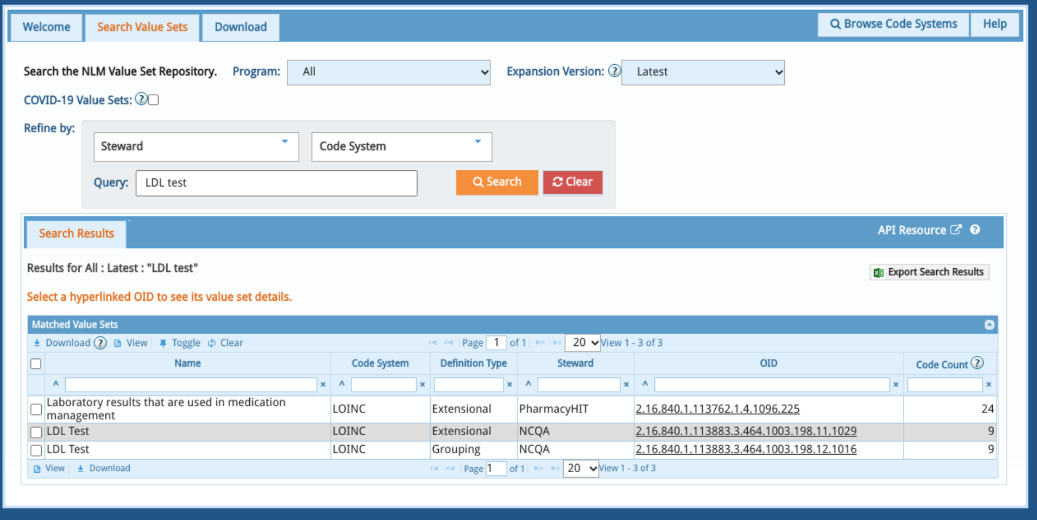

First we need to obtain the content. Users may create a value set table themselves and populate it as needed, but this library also supports the ability to connect to a FHIR terminology server and retrieve the needed values. The example below shows connecting to VSAC's terminology server and getting code values for statins, CHD, and LDL tests:

In [ ]:
# Value set URLs used in the queries
STATIN_MEDS = 'http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840.1.113883.3.117.1.7.1.225'
CHD_OR_RISK_EQUIV = 'http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840.1.113883.3.600.862'
LDL_TEST = 'http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840.1.113883.3.464.1003.198.11.1029'

In [ ]:
import getpass 
from google.fhir.r4.terminology import terminology_service_client

api_key = getpass.getpass('UMLS API KEY: ')

tx_client = terminology_service_client.TerminologyServiceClient({
    'http://cts.nlm.nih.gov/fhir/': ('apikey', api_key),
})
runner.materialize_value_set_expansion((STATIN_MEDS, LDL_TEST, CHD_OR_RISK_EQUIV), tx_client)

UMLS API KEY:  ····································


Now that we've downloaded that content, let's take a look at the value_set_codes table it produced:

In [ ]:
%%bigquery
SELECT * FROM 
statin_analysis_example.value_set_codes
WHERE valueseturi = 'http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840.1.113883.3.464.1003.198.11.1029'

Downloading: 100%|██████████| 9/9 [00:01<00:00,  6.23rows/s]


,valueseturi,valuesetversion,system,code
0,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,39469-2
1,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,2089-1
2,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,55440-2
3,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,18261-8
4,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,13457-7
5,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,18262-6
6,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,49132-4
7,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,22748-8
8,http://cts.nlm.nih.gov/fhir/ValueSet/2.16.840....,20170504,http://loinc.org,12773-8


We now have the value sets needed for some analysis stored in BigQuery, so let's use them for an important use case: identifying gaps in care.


# Identifying Statin Therapy Care Gaps
This section analyzes the use of statin therapy for patients who have been diagnosed with Coronary Heart Disease (CHD) or have equivalent risks. We achieve this by first identifying a cohort of patients and then measuring the percentage of them with the recommended therapy. 

Some of this content is based on the [Statin Therapy eCQM](https://ecqi.healthit.gov/system/files/ecqm/measures/CMS347v1.html).

## The cohort:
Patients who have either of the following during the measurement period:
* Coronary Heart Disease or equivalent risks (as defiend by CMS) OR
* An LDL-C greater than or equal to 180

## The measure:
The percentage of cohort members who have statin therapy. Let's take the complex FHIR data and create some simple views for our needs, starting with a view of all LDL values:



In [ ]:
ldl_obs = obs.select({
    'patient': obs.subject.idFor('Patient'),
    'value': obs.value.ofType('Quantity').value,
    'unit': obs.value.ofType('Quantity').unit,
    'test': obs.code.coding.display.first(),
    'effectiveTime': obs.effective.ofType('dateTime')
    }).where(obs.code.memberOf(LDL_TEST)) 

runner.to_dataframe(ldl_obs, limit=10)

,patient,value,unit,test,effectiveTime
0,cecccba1-aff0-4a4f-a006-1328c8d9d6d9,109.318001,mg/dL,Low Density Lipoprotein Cholesterol,1999-05-08 00:05:28
1,f25e1fbe-61d8-4fb3-920b-93194a4ec073,78.696342,mg/dL,Low Density Lipoprotein Cholesterol,2018-06-16 19:07:39
2,e1c7473f-7157-43d5-92bd-3aea2fad7dc4,65.050799,mg/dL,Low Density Lipoprotein Cholesterol,2014-06-17 02:32:12
3,c47973c3-9545-4ff4-bebf-2bad5623c2f9,105.962327,mg/dL,Low Density Lipoprotein Cholesterol,2014-01-06 00:47:58
4,f1a709d5-6c7a-4ed8-9960-a6831bd37a65,106.002977,mg/dL,Low Density Lipoprotein Cholesterol,2017-04-11 18:25:01
5,a8127123-fe08-4f34-8880-b5c8f9d19a7e,93.447833,mg/dL,Low Density Lipoprotein Cholesterol,2014-11-13 22:17:01
6,5437ef37-211d-47e9-a262-bbbe6eaf3fe5,91.599374,mg/dL,Low Density Lipoprotein Cholesterol,2012-05-27 13:32:48
7,a19d9025-8333-4354-b8bf-18e0b6ee74dd,126.566365,mg/dL,Low Density Lipoprotein Cholesterol,2016-04-21 12:33:12
8,2ecfe488-6ed1-4ba5-8bb2-482862d5d49c,95.587412,mg/dL,Low Density Lipoprotein Cholesterol,2010-08-30 20:05:34
9,77e9f01c-b489-43eb-8dea-c449c43fd01e,63.810224,mg/dL,Low Density Lipoprotein Cholesterol,2012-12-11 10:51:30


Now we can create it as a BigQuery view -- and *all* analysis that needs LDL values can simply use this nice, flattened table for that use case.

We recommend creating such simple, flattened tables for each major part of your analysis. That way they can be inspected and validated independently of the measure logic, making it much easier to separate and solve data and logic issues.

In [ ]:
runner.create_bigquery_view(ldl_obs, 'ldl_obs')

Let's do some minimal validation by plotting a random sample of all LDL values. 

You can see a clear bimodal distribution in this example. This is an artifact of the branching logic synthetic data generator used to create the data, where some generated patients are branched with conditions.

In [ ]:
%%bigquery ldl_values
SELECT value FROM statin_analysis_example.ldl_obs WHERE RAND() < 0.01

Downloading: 100%|██████████| 50353/50353 [00:01<00:00, 34662.26rows/s]


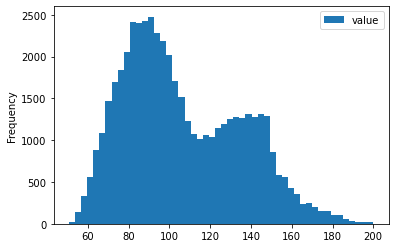

In [ ]:
ldl_values.plot.hist(bins=50);

Now we'll take a similar approach to another part of our analysis: a view of Coronary Heart Disease conditions or requivalent risks.

In [ ]:
chd_or_equiv_risks = conds.select({
        'patient': conds.subject.idFor('Patient'),
        'onsetTime': conds.onset.ofType('dateTime'),
        'code': conds.code.coding.code.first(),
        'display': conds.code.coding.display.first()
        }
    ).where(
        conds.code.memberOf(CHD_OR_RISK_EQUIV))

runner.create_bigquery_view(chd_or_equiv_risks, 'chd_or_equiv_risks')
runner.to_dataframe(chd_or_equiv_risks, limit=10)

,patient,onsetTime,code,display
0,ffc98fe9-3068-4b26-86d9-fbd3361d9eed,2014-04-09 13:34:11,53741008,Coronary Heart Disease
1,e1d92d70-2230-455b-8458-c0bb1c1da149,1996-11-09 11:44:32,127013003,Diabetic renal disease (disorder)
2,2f408bbb-f7fb-4b4d-800e-74824c615aa6,1993-11-29 02:09:06,127013003,Diabetic renal disease (disorder)
3,233cfaac-bbe9-498c-bfbd-1351b87c2ada,2003-07-31 13:32:10,53741008,Coronary Heart Disease
4,ea629e5c-05fd-4ebe-92e7-de77689d93d3,1997-04-19 17:34:37,53741008,Coronary Heart Disease
5,d66796e3-ec03-4f3b-835d-ef12ca40338a,2017-11-19 04:19:12,53741008,Coronary Heart Disease
6,256c0e4a-5b16-40fd-a330-463b1ff9f908,2018-06-28 16:27:15,53741008,Coronary Heart Disease
7,2c06cf16-1c56-4f48-a534-cd946fc1c598,1993-04-02 02:53:31,53741008,Coronary Heart Disease
8,9da29105-bd46-4b60-933e-bdd007f71264,1972-11-12 01:07:17,127013003,Diabetic renal disease (disorder)
9,76da8567-f81e-440f-af3f-dc8aab34f805,2000-08-29 20:52:30,44054006,Diabetes


Let's look at the condition codes to see if this looks reasonable. Notice that the value set defined for this analysis includes diabetes as a risk equivalent here, as seen in the reulting counts:

In [ ]:
%%bigquery
SELECT code, display, COUNT(*) count
FROM statin_analysis_example.chd_or_equiv_risks
GROUP BY code, display ORDER BY count DESC

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.41rows/s]


,code,display,count
0,44054006,Diabetes,81877
1,53741008,Coronary Heart Disease,73446
2,127013003,Diabetic renal disease (disorder),38968
3,427089005,Male Infertility,152
4,427089005,Diabetes from Cystic Fibrosis,121


And now for Statin medications:

In [ ]:
statin_meds = meds.select({
    'patient': meds.subject.idFor('Patient'),
    'authoredOn': meds.authoredOn
    }).where(
        meds.medication.ofType('CodeableConcept').memberOf(STATIN_MEDS))

runner.create_bigquery_view(statin_meds, 'statin_meds')

In [ ]:
%%bigquery
SELECT * FROM statin_analysis_example.statin_meds LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.59rows/s]


,patient,authoredOn
0,c5c68f13-fdf6-4658-8e95-81221879dce3,1991-08-28 22:28:28
1,6b5d314f-1f2b-4ab3-b7fb-e7b2bd526852,2008-04-25 03:01:35
2,1eda8dd1-cf95-47a0-bdf8-104315cbb9aa,2013-01-31 13:22:27
3,eb39ed67-8ecf-47c2-8075-ab37042b9237,2013-06-04 19:42:09
4,be575e37-9972-47aa-a06b-cbc626e16302,1999-10-13 15:16:25
5,851d2d89-d5c0-42c9-9ade-9ff8d4ac3684,1999-05-05 03:38:55
6,f6d701de-dbcb-4c66-8a8e-e13acdcee5f4,2008-08-08 13:42:26
7,9dac017e-2fa9-4874-a902-69a265ed48ba,2002-11-14 13:58:07
8,b4d5799f-98f1-486a-85da-045dca9929bd,1992-11-14 23:52:06
9,73d0d2d9-ab30-45a3-8c2f-b3df7892112f,2017-12-21 11:58:43


## Higher-level views for analysis
We've taken our first step: going from complex data structures and code systems with simple tables that meet our use case. Now we can continue this pattern by *layering* views to meet specific needs, modularizing and simplifying additional logic.

This quality measure indicates that statin mediations are needed if a patient has a high LDL vale *or* CHD or equivalent risk. We can join to the current tables for this in our measure logic, but let's eliminate that need by creating a single `statin_needed_events` view that simply indicates the patient, the date when the statin need arose, and a string indicating why.

In [ ]:
%%bigquery
CREATE OR REPLACE VIEW statin_analysis_example.statin_needed_events AS (
SELECT patient, 
       DATE(effectiveTime) date, 
       'High LDL' reason
FROM statin_analysis_example.ldl_obs
WHERE ldl_obs.value > 180
UNION ALL
select patient, 
       DATE(onsetTime) date, 
       display reason
FROM statin_analysis_example.chd_or_equiv_risks)

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 1075.74query/s]


""


In [ ]:
%%bigquery 
SELECT * FROM statin_analysis_example.statin_needed_events 
WHERE date >= '2018-01-01' 
ORDER BY date 
LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.37rows/s]


,patient,date,reason
0,8c8ad0f3-3775-4172-bad7-a27fd10ea169,2018-01-01,Diabetes
1,260bd457-ada3-4bf4-9f51-8e70a131e8d3,2018-01-01,Coronary Heart Disease
2,02ddd189-bcea-4c87-846a-0b733d9273fb,2018-01-01,Coronary Heart Disease
3,e8941f2f-d9f4-435c-9d81-4a8a04ac38f0,2018-01-01,Diabetes
4,22c48f04-efd6-4dd1-bf89-91a4399d4de0,2018-01-01,Diabetic renal disease (disorder)
5,7e2c4e74-1bfe-4ed4-9741-6ef3baee3174,2018-01-01,Coronary Heart Disease
6,ac7a773b-98dc-4585-b90b-aae288683509,2018-01-01,Diabetes
7,1a0ec6a4-4b13-4d81-8b1d-8c1f8bbf4fb8,2018-01-01,Coronary Heart Disease
8,add11af4-6957-4dbf-a8ee-424b7b3bd80f,2018-01-01,Coronary Heart Disease
9,671d14bf-1768-480c-b6b3-43947e42ed2d,2018-01-01,Coronary Heart Disease


This is effectively a time series of statin needed events that can be used for the quality measure and a number of other analytics, like tracking and trending by time, location, demographics, or other dimensions.

# Bringing it all together
Now we have the building blocks, so let's do our (simplified) care gap analysis itself. The key questions are for during the measurement period:

* Does the patient have a statin needed event as defined above? This is our population denominator.
* Is there a record of statin medications for that patient within 30 days of that event? This is the numerator of our measure.

We will support this by creating a simple view that brings together some patient demographics, the statin need information, and whether the patient actually got a statin medication within 30 days of the need. This is basically a join of the tables we created above:

In [ ]:
%%bigquery
CREATE OR REPLACE VIEW statin_analysis_example.statin_patient_population AS (
SELECT p.id,
       DATE_DIFF(CURRENT_DATE(), p.birthDate, YEAR) age,
       p.gender,
       p.zip,
       e.date needs_statin_date,
       e.reason needs_statin_reason,
       -- Look for statin medications within 30 days of the need
       EXISTS(SELECT * FROM statin_analysis_example.statin_meds m 
              WHERE m.patient = e.patient AND 
                    DATE_DIFF(e.date, DATE(m.authoredOn), DAY) BETWEEN -30 AND 30) got_statin
FROM statin_analysis_example.patients p 
JOIN statin_analysis_example.statin_needed_events e ON p.id = e.patient
)

Query complete after 0.00s: 100%|██████████| 1/1 [00:00<00:00, 795.13query/s] 


""


In [ ]:
%%bigquery
SELECT * FROM statin_analysis_example.statin_patient_population LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  6.79rows/s]


,id,age,gender,zip,needs_statin_date,needs_statin_reason,got_statin
0,8ef5e588-b0a6-426c-af66-3ef02898ef33,36,male,01038,1989-05-04,Coronary Heart Disease,False
1,638f12cd-cda0-4913-ac70-f988c6577fa6,40,male,01038,2016-04-21,Diabetes,False
2,c38ad129-5d5d-4275-9d0d-f38966683309,65,male,01038,1989-08-16,Coronary Heart Disease,False
3,cfec4c20-a6a5-4d68-812a-a01493420b67,64,male,01841,1965-10-27,Coronary Heart Disease,False
4,a6368228-23e1-47c5-ad96-1b6e3177a345,18,female,01841,2014-09-27,Coronary Heart Disease,True
5,e955e0ca-d327-4b0c-bef2-d9e2e3d84f72,54,male,01841,2010-10-03,Diabetes,False
6,8e69531f-27d9-49d4-b521-4d680c5890ed,113,male,01841,1945-10-11,Diabetic renal disease (disorder),False
7,8e69531f-27d9-49d4-b521-4d680c5890ed,113,male,01841,1934-11-08,Diabetes,False
8,9dc3c428-6f96-4875-8369-9b2f1d46afec,98,male,01841,1993-08-15,Diabetic renal disease (disorder),False
9,9dc3c428-6f96-4875-8369-9b2f1d46afec,98,male,01841,1966-06-26,Diabetes,False


The advantage of using BigQuery views is they are always up to date with the underlying data, but this comes at the cost of rerunning the entire analysis for the population each time. If this is too expensive for some workloads, users can either load data into an in-process dataframe if small enough, or materialize it in BigQuery.

Let's create a simple materialized form of the above for convenience here. In a real system, we might use BigQuery's scheduled query feature to regularly update it.

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE statin_analysis_example.statin_patient_population_materialized AS SELECT * FROM statin_analysis_example.statin_patient_population

Query complete after 0.00s: 100%|██████████| 54/54 [00:00<00:00, 23263.40query/s]                      


""


Finally, we do a simple rollup to see who needs statin medications and who got them:

In [ ]:
%%bigquery
SELECT needs_statin_date is NOT NULL needs_statin,
       got_statin,
       COUNT(*) count
FROM statin_analysis_example.statin_patient_population_materialized
WHERE needs_statin_date BETWEEN '2018-01-01' AND '2018-12-31'
GROUP BY needs_statin, got_statin

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.34rows/s]


,needs_statin,got_statin,count
0,True,False,4922
1,True,True,2187


And of course we can break this down by further dimensions. For example, we may need to identify which zip code has the biggest need here so we can allocate resources accordingly:

In [ ]:
%%bigquery
SELECT zip, COUNT(*) needs_statin_count
FROM statin_analysis_example.statin_patient_population_materialized 
GROUP BY zip ORDER BY needs_statin_count DESC 
LIMIT 5

Downloading: 100%|██████████| 5/5 [00:01<00:00,  3.46rows/s]


,zip,needs_statin_count
0,02108,19422
1,01013,7532
2,01545,7047
3,02138,6918
4,01850,3820


Finally, in this and many cases, we've constrained the data to a subset that can be loaded into an in-process dataframe and analyzed locally. This can be much faster and less costly, so let's go ahead and create a statin data frame for our analysis year and explore it in memory:

In [ ]:
%%bigquery statin_needs
SELECT * 
FROM statin_analysis_example.statin_patient_population_materialized
WHERE needs_statin_date BETWEEN '2018-01-01' AND '2018-12-31'

Downloading: 100%|██████████| 7109/7109 [00:01<00:00, 4981.82rows/s]


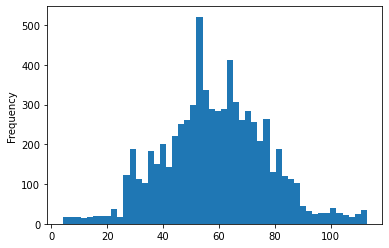

In [ ]:
statin_needs['age'].plot.hist(bins=50);

And here's a list of the most common reasons the population needs statin medications:

In [ ]:
statin_needs.groupby(['needs_statin_reason'])['needs_statin_reason'] \
            .count() \
            .sort_values(ascending=False) \
            .to_frame().head()

,needs_statin_reason
needs_statin_reason,
High LDL,2538
Coronary Heart Disease,2173
Diabetes,1541
Diabetic renal disease (disorder),853
Male Infertility,3


# Building on the Views
That's it for this notebook! We now have BigQuery views in place that can easily summarize the key dimensions and metrics needed to track this measure. From here users can use their analytics tool of choice, like [Google Data Studio](https://datastudio.google.com/) to create dashboards or other tools needed for users to help identify and close care gaps.